In [64]:
%matplotlib inline

import pandas as pd
import numpy as np
import gc
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import log_loss

import xgboost as xgb

sns.set_style('dark')

import warnings
warnings.filterwarnings('ignore')

SEED = 123131
np.random.seed(SEED)

# Load Files

In [89]:
train = pd.read_csv('../data/raw/4b699168-4-here_dataset/train.csv')
test  = pd.read_csv('../data/raw/4b699168-4-here_dataset/test.csv')
sub   = pd.read_csv('../data/raw/4b699168-4-here_dataset/sample_submission.csv')

In [90]:
# rename target column

train = train.rename(columns={
    'SignFacing (Target)': 'target'
})

In [91]:
# combine dataset
data = pd.concat((train, test))
train_mask = data.target.notnull()

del train, test
gc.collect()

916

In [58]:
def print_nunique(feature_name):
    print('Number of unique values in the training set {}'\
      .format(data.loc[train_mask, feature_name].nunique()))
    print('Number of unique values in the test set {}'\
          .format(data.loc[~train_mask, feature_name].nunique()))
    
    
def missing_values(feature_name):
    print('{} missing in train set but present in the test set'\
      .format(set(data.loc[~train_mask, feature_name]) - set(data.loc[train_mask, feature_name])))

In [6]:
# number of unique values of angle of sign variable
print_nunique('AngleOfSign')

Number of unique values in the training set 353
Number of unique values in the test set 358


In [20]:
# values that are present in the training set but not in the test set
missing_values('AngleOfSign')

{0, 2, 356, 358, 167, 143, 177, 184} missing in train set but present in the test set


In [21]:
# number of unique values of detected camera 
print_nunique('DetectedCamera')

Number of unique values in the training set 4
Number of unique values in the test set 4


In [22]:
# values that are missing in the training set but present in the test set for DetectedCamera
missing_values('DetectedCamera')

set() missing in train set but present in the test set


In [23]:
print_nunique('SignAspectRatio')

Number of unique values in the training set 172
Number of unique values in the test set 168


In [24]:
missing_values('SignAspectRatio')

{0.27000000000000002, 1.9299999999999999, 2.0, 2.1800000000000002, 2.3300000000000001, 2.5800000000000001, 1.8400000000000001, 1.9199999999999999, 2.0699999999999998} missing in train set but present in the test set


In [25]:
print_nunique('SignHeight')

Number of unique values in the training set 371
Number of unique values in the test set 349


In [26]:
missing_values('SignHeight')

{448, 355, 419, 325, 420, 328, 330, 299, 363, 394, 395, 335, 367, 398, 306, 400, 402, 345, 379} missing in train set but present in the test set


In [27]:
print_nunique('SignWidth')

Number of unique values in the training set 371
Number of unique values in the test set 357


In [28]:
missing_values('SignWidth')

{384, 385, 397, 399, 529, 18, 428, 431, 439, 441, 314, 323, 340, 342, 344, 361, 364, 499, 375, 380, 382} missing in train set but present in the test set


In [29]:
pd.crosstab(data.loc[train_mask, 'DetectedCamera'], data.loc[train_mask, 'target'])

target,Front,Left,Rear,Right
DetectedCamera,,,,
Front,10759,101,0,50
Left,1005,541,7752,0
Rear,0,33,7657,71
Right,9563,0,253,700


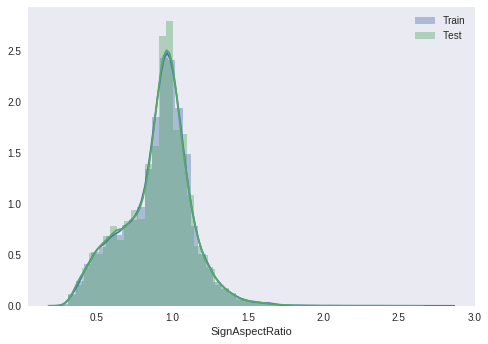

In [30]:
# distribution of sign aspect ratio
sns.distplot(data.loc[train_mask, 'SignAspectRatio'], label='Train')
sns.distplot(data.loc[~train_mask, 'SignAspectRatio'], label='Test')
plt.legend(loc='best');

In [44]:
# sign aspect count with target variable
sign_aspect_count = data.loc[:, :].groupby('SignAspectRatio')['SignAspectRatio'].transform(lambda x: len(x))
data = data.assign(sign_aspect_count=sign_aspect_count)

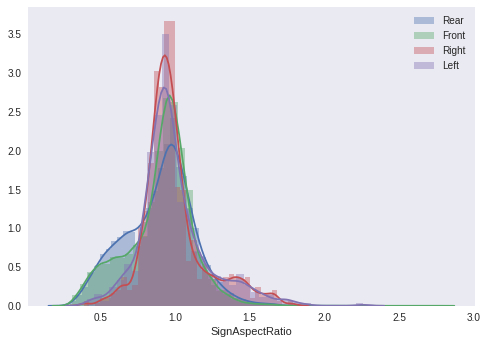

In [36]:
sns.distplot(data.loc[train_mask & (data.target == 'Rear'), 'SignAspectRatio'], label='Rear')
sns.distplot(data.loc[train_mask & (data.target == 'Front'), 'SignAspectRatio'], label='Front')
sns.distplot(data.loc[train_mask & (data.target == 'Right'), 'SignAspectRatio'], label='Right')
sns.distplot(data.loc[train_mask & (data.target == 'Left'), 'SignAspectRatio'], label='Left')
plt.legend(loc='best');

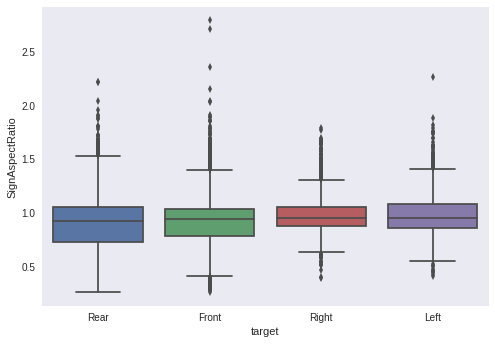

In [32]:
sns.boxplot(x='target', y='SignAspectRatio', data=data.loc[train_mask, :]);

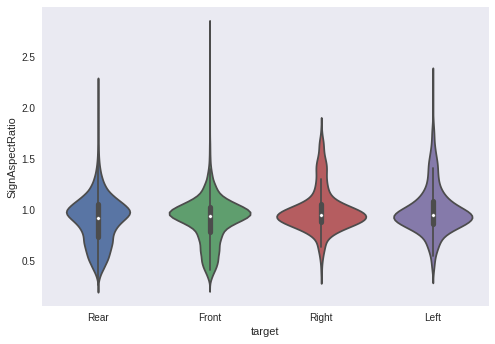

In [34]:
sns.violinplot(x='target', y='SignAspectRatio', data=data.loc[train_mask, :]);

In [48]:
data.loc[train_mask, :].pivot_table(index='DetectedCamera', 
                                    columns='target', 
                                    values='SignAspectRatio',
                                    aggfunc=np.mean,
                                   )

target,Front,Left,Rear,Right
DetectedCamera,,,,
Front,0.978286,1.213069,NaN,1.155400
Left,0.741701,0.938078,0.788595,NaN
Rear,NaN,1.172424,1.002412,1.215070
Right,0.826725,NaN,0.924901,0.960114


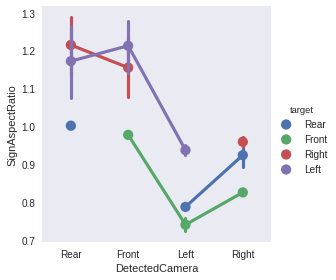

In [50]:
sns.factorplot(x='DetectedCamera', y='SignAspectRatio', 
               hue='target', data=data.loc[train_mask, :]);

** Basic Pipeline **

* Data Processing
* Featue Generation

In [68]:
class DataProcessing(BaseEstimator, TransformerMixin):
    """
    Preprocessing Tasks
    """
    
    def fit(self, X, y):
        pass
    
    def fit_transform(self, X, y=None):
        pass
    
class FeatureGeneration(BaseEstimator, TransformerMixin):
    """
    Feature Generation Ideas
    ========================
    1. Deviation of SignAspectRatio from 1.
    2. Whether detected camera is in front or rear position or not.
    """
    def __init__(self):
        return None
    
    def fit(self, X, y):
        X['deviation'] = 1 - X['SignAspectRatio']
        
        detected_camera_position = X['DetectedCamera'].isin([0, 1]).astype(np.int)
        X = X.assign(detected_camera_position=detected_camera_position)
        
        return self
    
    def transform(self, X, y=None):
        X['deviation'] = 1 - X['SignAspectRatio']
        
        detected_camera_position = X['DetectedCamera'].isin([0, 1]).astype(np.int)
        X = X.assign(detected_camera_position=detected_camera_position)
        
        return X
    
class VarSelect(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y):
        return self
    
    def transform(self, X, y=None):
        return X[self.features]

** Create X and y **

In [92]:
target_map = {
    'Front': 0,
    'Rear' : 1,
    'Left' : 2,
    'Right': 3
}

In [93]:
X                   = data.loc[train_mask, ['AngleOfSign', 'DetectedCamera', 'SignAspectRatio']]
X['DetectedCamera'] = X.DetectedCamera.map(target_map)

y = data.loc[train_mask, 'target'].map(target_map)

Xtest = data.loc[~train_mask, ['AngleOfSign', 'DetectedCamera', 'SignAspectRatio']]
Xtest['DetectedCamera'] = Xtest.DetectedCamera.map(target_map)

** split data into training and test set **

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=SEED)

** Define a model **

In [106]:
model = RandomForestClassifier(n_estimators=500,
                               max_depth=10,
                               min_samples_split=3,
                               n_jobs=-1,
                               random_state=SEED)

In [31]:
model = xgb.XGBClassifier(max_depth=2, learning_rate=.05, n_estimators=708, min_child_weight=3.0, 
                          subsample=.85, gamma=.9)

** Define Pipeline **

In [107]:
pipeline = Pipeline(steps=[
    ('feature_generation', FeatureGeneration()),
    ('select', VarSelect(['AngleOfSign',
                          'deviation'])),
    ('model', model)
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict_proba(X_test)
print('Log loss: {}'.format(log_loss(y_test, preds)))

Log loss: 0.11322442842106473


In [109]:
100 - .11322

99.88678

** Full Training **

In [108]:
pipeline.fit(X, y)
final_preds = pipeline.predict_proba(Xtest)

In [104]:
sub.iloc[:, 1:] = final_preds

In [105]:
sub.to_csv('../submissions/predict_sign/rf_experiment_14.csv', index=False)